==============================================================================================
# Practicum 5 - Part 1

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- The questions introduced in the exercises must be answered.

- Implemented code should be commented.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.

**Deadline: December 6th, 23:00 h**


==============================================================================================
##  Image search using textures
==============================================================================================

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.

The exercises of this notebook will show how we can perform image similarity search using:

- Gaussian filters
- Descriptors based on texture 
- Distance between images and similarity search


### Imports

In [1]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize


import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 1 Derivative of Gaussians aka Leung-Malik (LM) Filter Bank
We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Derivative-of-Gaussians or as known as Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


We import Leung-Malik filters as follows:

In [2]:
import LM_filters
filter_bank = LM_filters.makeLMfilters()

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


### Plotting all filters

Plot the created filters as images similar to the figure above.

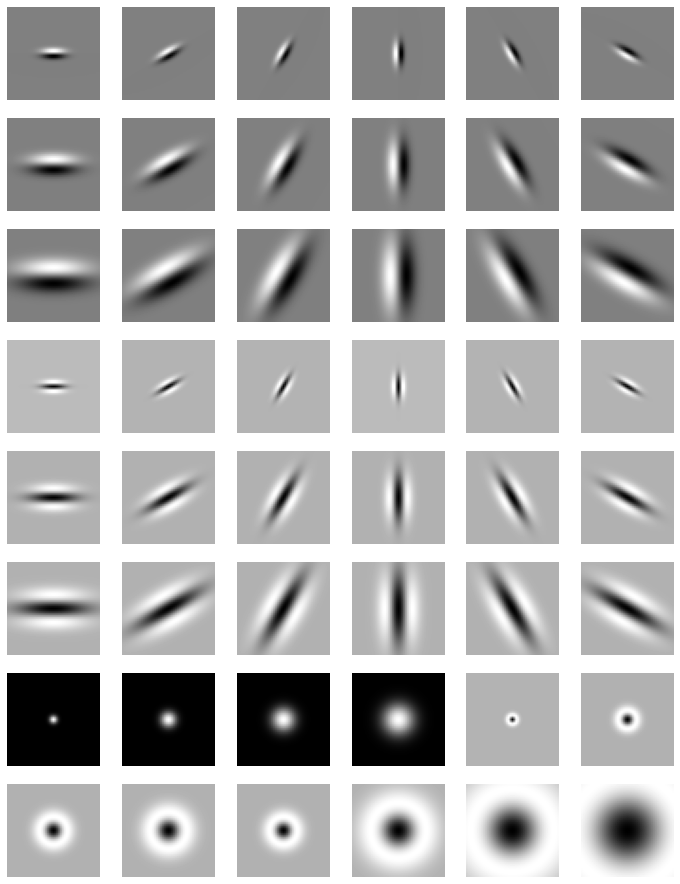

In [19]:
fig, axs = plt.subplots(8, 6, figsize=(12, 16))
for i in range(8):
    for j in range(6):
        axs[i, j].imshow(filter_bank[:, :, i*6+j], cmap='gray')
        axs[i, j].axis('off')
plt.show()

What are the different filters? Which is the size of the filters? How many filters there are?

The first 18 are the ones that in the figure are labeled as 'Edges'. These correspond to first Gaussian derivative filters at 6 orientations and 3 scales, which is generally used to detect edges.

The second 18 are the ones that in the figure are labeled as 'Bars'. These correspond to second Gaussian derivative filters at 6 orientations and 3 scales, which are generally used to detect somewhat straight lines (thick or not) in an image (or bars, like the label says).

The last 12 filters are the ones in the figure that are labeled as 'Spots'. The 4 darker ones are Gaussian filters and the other 8 are Laplacian of Gaussian filters.

There are 48 in total and their size is 49x49 pixels.

## 1. Extracting a feature vector for an image

**1.1** Read the image ``/images/pizza.jpg``, and resize it to 240𝑥240 pixels. Then, convert the image to grayscale and visualize both, the RGB and the grayscale images.

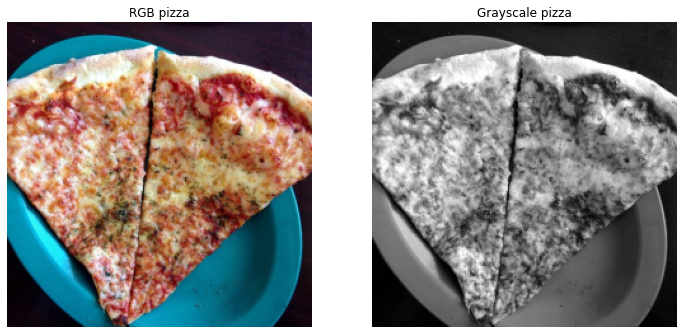

In [24]:
pizza = imread('images/pizza.jpg')
pizza = resize(pizza, (240, 240))
pizza_gray = rgb2gray(pizza)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(pizza)
axs[0].axis('off')
axs[0].set_title('RGB pizza')

axs[1].imshow(pizza_gray, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Grayscale pizza')

plt.show()

**1.2** Given $D=n\_{filters}$ filters from the filter bank and a single image `image`, make a function `get_image_features(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$

Try the function with the previous image and print the feature vector.

**Hint**: The function should return a feature vector obtained by averaging each filter response on the image. Use a small number of filters to try your functions

In [45]:
def get_image_features(image, filter_bank, n_filters):
    for i in range(n_filters):
        yield np.mean(np.abs(scipy.signal.convolve2d(image, filter_bank[:, :, i])))

In [46]:
## Try the function
n_filters = 5
im_features = get_image_features(pizza_gray, filter_bank, n_filters)
print('Features: ', list(im_features))


**1.3** (Optional) Try ``extract_features()`` using a different number of filters and other images (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)


In [74]:
from skimage.transform import rescale

dog = imread('images/dog.jpg', as_gray=True)
flower = rescale(imread('images/flower.jpg', as_gray=True), 0.5)

dog_features = list(get_image_features(dog, filter_bank, 8))
flower_features = list(get_image_features(flower, filter_bank, 10))

print('Dog Features', dog_features)
print('Flower', flower_features)

Dog Features [0.007084315286591017, 0.006807593752891214, 0.006534369039543032, 0.006443082871227878, 0.007209582717571712, 0.007580079914905146, 0.005408833326238149, 0.005256946421295202]
Flower [0.009981227664147777, 0.010165867837511545, 0.010143494422364915, 0.009696323448729114, 0.009800461390467575, 0.010037539076024383, 0.007110542987357663, 0.007300985289658366, 0.007087513870335858, 0.006737920090117998]


### Visualizing features

**1.3** Make a function `visualize_features(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png" >

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

In [79]:
def visualize_features(im, filter_bank, n_filters=5):
    fig, axs = plt.subplots(nrows=2, ncols=n_filters, figsize=(16, 5))
    for i in range(n_filters):
        axs[0, i].imshow(np.abs(scipy.signal.convolve2d(im, filter_bank[:, :, i])), cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title('Convolved {}'.format(i))
        axs[1, i].imshow(filter_bank[:, :, i], cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title('Filter {}'.format(i))

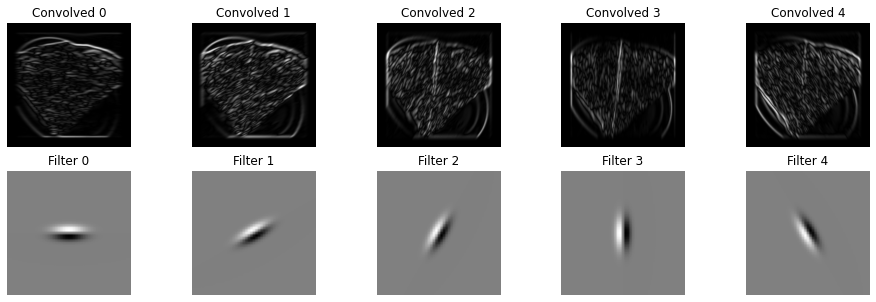

In [80]:
## Try the function
visualize_features(pizza_gray, filter_bank)

**1.4** (Optional) Try ``visualize_filters()`` using a different number of filters and using another image (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)

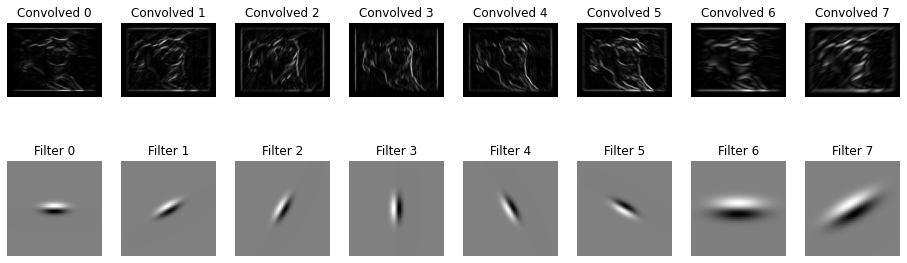

In [81]:
visualize_features(dog, filter_bank, 8)

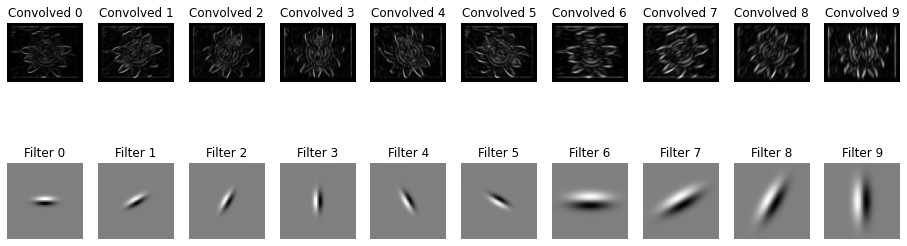

In [82]:
visualize_features(flower, filter_bank, 10)

## 2 Load & resize the dataset

**2.1** Read all the images in the directories, resize them to 240x240 pixels and save the image in an array:

<ul>
    <li>./images/pizza/</li>
    <li>./images/flowers/</li>
    <li>./images/pets/</li>
</ul>

**Hint:** You have to create an array for each directory, which containts all the images belonging to that path.

In [106]:
import os

pizza_images = [imread(os.path.join('images/pizza', f)) for f in os.listdir('images/pizza')]
flowers_images = [imread(os.path.join('images/flowers', f)) for f in os.listdir('images/flowers')]
pets_images = [imread(os.path.join('images/pets', f)) for f in os.listdir('images/pets')]

Visualize one image (the first) from each array. Use ``subplot`` to create a 3x1figure.

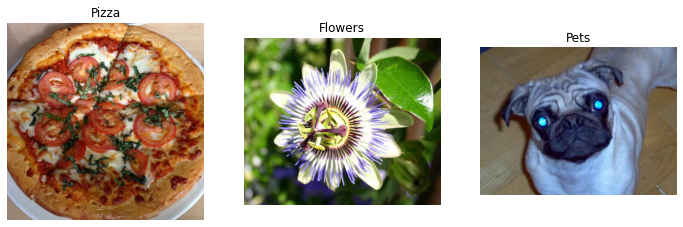

In [107]:
fig, axs = plt.subplots(1, 3, figsize=(12, 12))

axs[0].imshow(pizza_images[0])
axs[0].axis('off')
axs[0].set_title('Pizza')

axs[1].imshow(flowers_images[0])
axs[1].axis('off')
axs[1].set_title('Flowers')

axs[2].imshow(pets_images[0])
axs[2].axis('off')
axs[2].set_title('Pets')

plt.show()

How many images there are in each directory?

In [108]:
len(pizza_images), len(flowers_images), len(pets_images)

(30, 29, 29)

### Constructing the matrix of the feature vectors for all images

**2.2** Implement a function `get_dataset_features(all_images, filter_bank, n_filters=6)` that applies `extract_features` to get a feature vector for each of the images in the union of the three datasets (fish and chips_images, pizza, paella). It must return a matrix containing at row $k$ feature vector for the input image $k$.

Try the function with the whole data set:

*all_images = pizza_images + flowers_images + pets_images*

In [129]:
from skimage.transform import rescale
import tqdm

def get_dataset_features(all_images, filter_bank, n_filters=6):
    image_features = np.zeros((len(all_images), n_filters))
    for i in tqdm.trange(len(all_images)):
        im = rgb2gray(all_images[i])
        while im.size > 200*300:
            im = rescale(im, 0.75)
        image_features[i] = list(get_image_features(im, filter_bank, n_filters))
    return image_features

In [130]:
## Try the function
all_images = pizza_images + flowers_images + pets_images
feature_vectors = get_dataset_features(all_images,  filter_bank, n_filters)

100%|██████████| 88/88 [01:38<00:00,  1.12s/it]


**2.3** Print the shape of `feature_vectors` as well as the features for image #3 (*i.e. all_images[3]*), image #33, and image #53, directly from the vector

In [132]:
print(feature_vectors.shape)

(88, 5)


### Visualizing the features of an image

**2.4** Define a function `visualize_features(im_index, feature_vector)` that given three different images, plots their features. Use different colors (red, green, and blue) to distinguish the features of each image.
Choose 3 images on your choice and visualize the results.

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

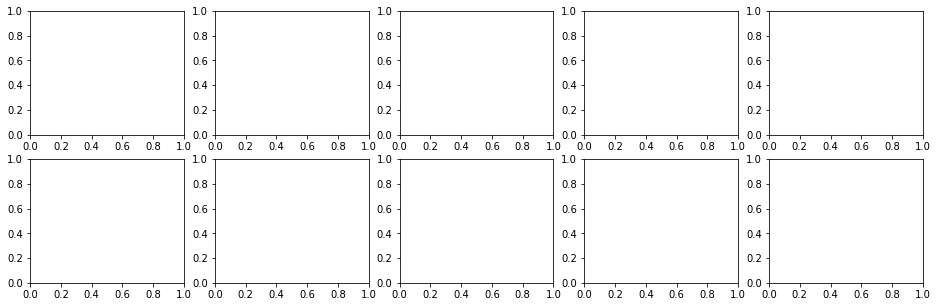

In [131]:
## Try the function
visualize_features( [3,33,53] , feature_vectors)

**2.5** (Optional) Try the function using a different set of images

In [ ]:
# Your solution here

Explain which features are most important to a given image and with each derivatives are related.


# 3 Retrieving the most similar images

### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$



**3.1** Implement a function `retrieve_images(im_features, feature_vectors, k=5)` to retrieve and visualize the `k` most similar images (according to the l2 norm) to `im` and the corresponding distances.

The input of this function need to be feature of the image of interest `im_features`, the whole data set features `feature_vectors`, and an integer value `k`, which defines the number of images.

The function should return the ordered vector of distances and the index of the closests images.

In [ ]:
# Your solution here

Try your function using ``/images/pizza.jpg``.

In [ ]:
# Try your function
closest, distances = retrieve_images( im_features, feature_vectors, k=5)

**3.2** Write a function *show_closest_images(all_images, closest, distances)* to show the closest images and the corresponding distances. 

<img src="./images/indice.png" >


In [ ]:
# Your solution here

In [ ]:
show_closest_images(all_images, closest, distances)

**3.3** Try your function using a different number of closest images `k`.

In [ ]:
# Your solution here

**3.4** (Optional) Try your function using ``/images/dog.jpg``, and ``/images/flower.jpg``

In [ ]:
# Your solution here

# 4 Compute the accuracy of the algorithm: given a query image. 

**4.1** Implement a function `accuracy(feature_vectors, class_labels, im_features, class_im,  k=5)`, which takes as input `feature_vectors`, the `class_labels` for the images (`0 = pizza`, `1 = flower` and `2 = pet`), the number of images to retrieve `k`, a query image (i.e. the feature vector for the image of interest) and the class of the query image `class_im`. 

Returns as output the number of retrieved images that belong to class `class_im` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: Be careful to exclude the query image from the retrieved images (i.e. those cases in which `distance=0.0`)

In [ ]:
# Your solution here


In [ ]:
print("acc:", accuracy(im_features, 0, feature_vectors, class_labels, k=5))

Compute the accuracy with k=10 with the previous images. Does the accuracy match the images retrieved from the previous exercise?

**4.2** (Optional) Try your function using other images and modifying the number of filters to be used.

**Hint:** You can use `im_features = feature_vectors[j]` and `class_im = class_labels[j]`, for a given `j` value, in order to simplify the problem, instead of recomputing the features for a new image. **Remember** to exclude the query image from the retrieved images!.

In [ ]:
# Your solution here

### Feature normalization

**4.3** As you can see in exercise 2.4, some features are higher than the rest and, therefore, they are "more important" during the image retrieving.

Normalize each feature between **[0,1]** using the minimum and the maximum values obtained from `feature_vectors`. Note that we need to use these values to normalize `im_features`.

Plot the new features of an image, using `visualize_features()`. Then, show the 5 closest images from `im_features` and compute the accuracy. Is there any difference? Do we obtain the same images than previously?

In [ ]:
# Your solution here

In [ ]:
print("acc:", accuracy(new_im_features, 0, new_feature_vectors, class_labels, k=5))


# 5 Image retrieval based on texture and color. 

**5.1** Make a function ` lm_features_rgb(rgb_image, n_bins=12)`  that returns the features based on a color descriptor (using histograms, as it was performed in the **Deliverable 3 - video segmentation**). 

**Hint:** How will you define it? What should be the dimensonality of the new descriptor?.

In [ ]:
# Your solution here

In [ ]:
# Try your function
lm_rgb_features = lm_features_rgb(pizza)
print(len(lm_rgb_features))


## Apply the function to all the images in the dataset

**5.2** Using ` lm_features_rgb` build the features of all the datapoints in and save them in `lm_dataset_features`.

**Hint:** You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [ ]:
%%time 
'''
Solution
'''

In [ ]:
import joblib
X_lm_rgb = joblib.Parallel(n_jobs=8)(joblib.delayed(lm_features_rgb)(im) for im in all_images)

## Compute the accuracy of the method using lm rgb features

**5.3** Compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

Is the accuracy higher? Please, comment the results.

In [ ]:
# Your solution here

## Compare the accuracy of the method using a) texture, b) color and c) texture + color  features

**5.4** Compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

Is the accuracy higher? Please, comment the results.

In [ ]:
# Your solution here

**5.5** Compute the accuracy of the retrieved images using the features that contain texture and color information. Make a plot of the 4 closest images to the query images in the `lm_rgb_texture` space.

Is the accuracy higher? Please, comment the results.

In [ ]:
# Your solution here